In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
import joblib
import warnings

from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

import matplotlib.ticker as mtick

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import svm

In [2]:
df = pd.read_csv('../data/CoilData.csv')
coils = pd.read_csv('../data/output.csv')
coil_list = list(map(int,list(coils.columns)))
lst = []
for i in df['coil']:
    if i in coil_list:
        lst.append(1)
    else:
        lst.append(0)
df['contracted'] = lst
df['analyse_main'] = [i[0:3] for i in df['analyse']]
dummies_analyse_main = pd.get_dummies(df['analyse_main'], dtype=float)

### Bad coils exploration

In [3]:
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore")

bad_c = df[df['contracted']==1]
bad_c['analyse_main'] = [i[:-2] for i in bad_c['analyse']]

In [4]:
len_main = len(bad_c.analyse_main.value_counts())
ratio_of_total = int(len_main/10)/len_main
top_ninety_percentile = bad_c.analyse_main.value_counts(ascending=False).head(int(len_main/10)).sum()
the_rest = bad_c.analyse_main.value_counts(ascending=True).head(len_main - int(len_main/10)).sum()
ratio = 1 - (the_rest/top_ninety_percentile)

print(f'The top {ratio_of_total}% of most recurring main categories count for {ratio * 100}% of the total number of contracted coils')

The top 0.09090909090909091% of most recurring main categories count for 41.37734775184975% of the total number of contracted coils


In [5]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# get list of 20% most recurring categories
top_bad_main_categories = bad_c.analyse_main.value_counts(ascending=False).head(int(len_main/10)).index.tolist()

# add column if coil in category
in_main_category = []
for coil in bad_c['analyse']:
    if coil[:-2] in top_bad_main_categories:
        in_main_category.append(1)
    else:
        in_main_category.append(0)

bad_c['is_in_main_top_main_categories'] = in_main_category
bad_coil_list = list(bad_c.coil[bad_c['is_in_main_top_main_categories'] == 1])

In [6]:
# removing columns
coil_list = df.coil
df = df.drop(columns=['coil', 'analyse', 'analyse_main', 'furnace Number', 'Temperature before finishing mill', 
                      'Temperature after finishing mill'])
data = df.copy()
print(data.head())

   Hardness_1  Hardness_2   Width  Thickness Thickness profile    c    mn  \
0       10003         101  1302.1       4.36                31  355  2162   
1       10123         101  1282.3       4.37                35  551  1985   
2       10040         102  1297.4       4.43                25  457  1895   
3       10243         102  1295.2       4.44                28  697  2008   
4       10012         100  1293.3       3.95                26  477  1936   

    si  nb    p    s   al   ma  b   n  ti   cr  va  mo  contracted  
0   49   0  133  143  304  291  1  34   6  302   0  25           1  
1  101   0  118   90  395  384  1  33  12  189  25   7           0  
2   60   0  108  115  476  463  1  20  11  288   0  40           0  
3   69   0  139   98  306  296  1  21   9  253   0   9           0  
4   52   0  112  121  340  329  1  28   8  297   0  23           0  


In [7]:
# replace string values in Thickness profile column
data['Thickness profile'] = data['Thickness profile'].apply(lambda x: x.replace('*******', ''))
data = data.replace('', np.nan, regex=True).dropna().astype(float)
data = data[data['Thickness profile'] >= 0]

## Transform data

In [8]:
# Standardize data
# scaler = StandardScaler()
# selection_standardize = data.iloc[:,0:5]
# list_columns = selection_standardize.columns
# scaled_selection = pd.DataFrame(data=scaler.fit_transform(selection_standardize), columns=[list_columns])
# print(scaled_selection)

In [9]:
# Transform to log data and replace -inf values with min value != 0 
# in each column and get the log of that number divided by 1000

log_selection = data.iloc[:,0:19]
for column in list(log_selection.columns):
    min_value_per_column = min(i for i in log_selection.loc[:,column] if i > 0)
    log_selection.loc[:,column] = np.log(log_selection.loc[:,column]).replace(-np.inf, np.log(min_value_per_column/1000))

In [10]:
# Join dataframes and adding OneHotEncoding for Categorical values of 'Analyse' column
# data = scaled_selection.join(log_selection).join(dummies_analyse_main).join(df['contracted']).join(coil_list).dropna()
data = log_selection.join(dummies_analyse_main).join(df['contracted']).join(coil_list).dropna()

## Data selection and partitioning

In [11]:
# Making balanced datasets
# in_bad_coil_list = []
# for coil in data['coil']:
#     if coil in bad_coil_list:
#         in_bad_coil_list.append(1)
#     else:
#         in_bad_coil_list.append(0)
# data['in_bad_coil_list'] = in_bad_coil_list

# df_bad_coils = data[data['in_bad_coil_list']==1].reset_index().drop(columns=['coil',
#                                                                              'in_bad_coil_list',
#                                                                              'Thickness profile',
#                                                                              'index'])
# len_bad_coil_list = len(df_bad_coils)
# print(len_bad_coil_list)
# print(df_bad_coils.head().T)


df_bad_coils = data[data['contracted'] ==1].reset_index().drop(columns=['coil',
#                                                                              'in_bad_coil_list',
                                                                             'Thickness profile',
                                                                             'index'])

len_bad_coil_list = len(df_bad_coils)
print(df_bad_coils)

df_good_coils = data[data.contracted == 0].sample(len_bad_coil_list).reset_index().drop(columns=['coil',
#                                                                                                  'in_bad_coil_list',
                                                                                                 'Thickness profile',
                                                                                                 'index'])
df_good_coils.to_csv('df_good_coils.csv', index=True, header=True)
df_good_coils = pd.read_csv('df_good_coils.csv').drop(columns=['Unnamed: 0']).dropna()
print(df_good_coils.head().T)

      Hardness_1  Hardness_2     Width  Thickness         c        mn  \
0       9.210640    4.615121  7.171734   1.472472  5.872118  7.678789   
1       9.213635    4.605170  7.375882   1.420696  5.849325  7.593374   
2       9.200189    4.595120  7.344525   1.337629  5.828946  7.679714   
3       9.254453    4.653960  7.242726   0.924259  6.658011  8.149602   
4       9.222467    4.615121  7.170196   0.841567  6.236370  7.653020   
...          ...         ...       ...        ...       ...       ...   
2772    9.227591    4.488636  7.375882   1.308333  2.944439  6.784457   
2773    9.252154    4.532599  7.358194   1.252763  2.995732  7.029973   
2774    9.257796    4.521789 -0.468724  -6.571283  2.995732  6.867974   
2775    9.187788    4.584967  7.270174   0.924259  5.860786  7.554335   
2776    9.199987    4.595120  7.290293   0.850151  6.035481  7.462215   

            si        nb         p         s  ...  T26  T27  T69  TB0  TB3  \
0     3.891820 -6.907755  4.890349  4.962845 

In [12]:
# concat even number of good and bad coils in df and reshuffle the dataframe so we randomize the the data when we
# split it. 
df_balanced_coils = pd.concat([df_good_coils, df_bad_coils]).sample(frac=1).reset_index(drop=True).dropna()
print()
X = df_balanced_coils.iloc[:,:-1]
y = df_balanced_coils.contracted
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(df_bad_coils), len(df_good_coils))
print(np.any(np.isnan(df_balanced_coils)))


2777 2777
False


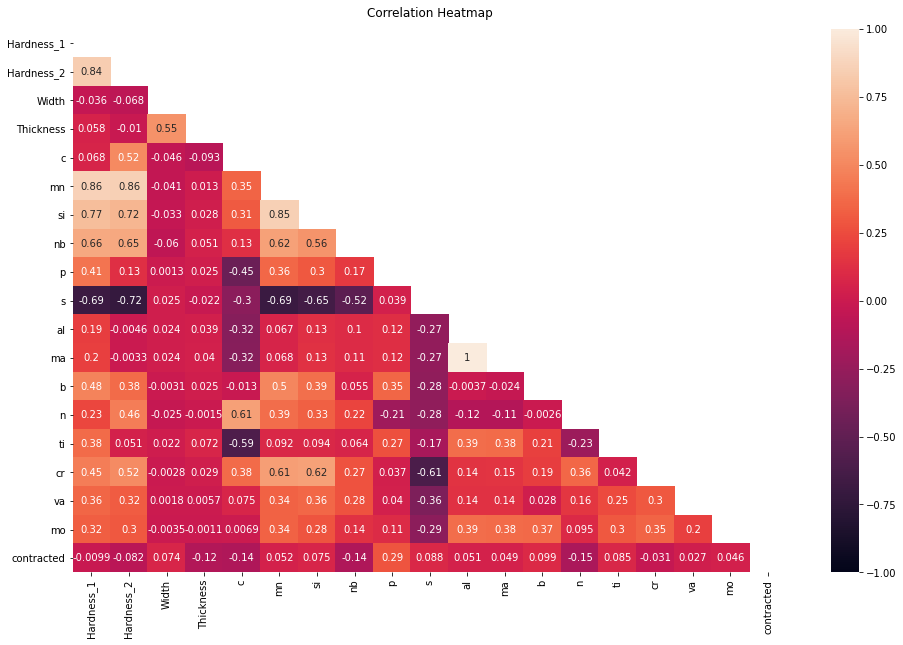

In [13]:
# Correlation Heatmap
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(df_balanced_coils.iloc[:,:18].join(df_balanced_coils.contracted).corr(), dtype=np.bool))
heatmap = sns.heatmap(df_balanced_coils.iloc[:,:18].join(df_balanced_coils.contracted).corr(),mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Baseline modeling

In [14]:
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
svm = svm.SVC(random_state=42)
gaus = GaussianNB()
bernoul = BernoulliNB()

In [15]:
# Set grid search params
max_depth_range = np.arange(3,15,3)
max_iter = np.arange(100,1000,100)

grid_params_lr = [{'multi_class': ['auto', 'ovr', 'multinomial'],
                  'max_iter': [1000]}]

grid_params_dt = [{'criterion': ['gini', 'entropy'],
                  'max_depth': max_depth_range}]

grid_params_rf = [{'criterion': ['gini', 'entropy'],
        'max_depth': max_depth_range,
        'min_samples_split': max_depth_range}]

grid_params_svm = [{'kernel': ['linear', 'rbf'], 
        'C': max_depth_range}]

grid_params_gaus = [{'var_smoothing': np.logspace(0, -9, num=100)}]

grid_params_bernoul = [{'alpha':np.linspace(0.1,1,10)}]

In [16]:
LR = GridSearchCV(lr,
            param_grid=grid_params_lr,
            scoring='accuracy',
            cv=3)

DT = GridSearchCV(dt,
                 param_grid=grid_params_dt,
                 scoring='accuracy',
                 cv=3)

RF = GridSearchCV(rf,
                 param_grid=grid_params_rf,
                 scoring='accuracy',
                 cv=3)

SVM = GridSearchCV(svm,
                  param_grid=grid_params_svm,
                  scoring='accuracy',
                  cv=3)

GAUS = GridSearchCV(gaus,
                  param_grid=grid_params_gaus,
                  scoring='accuracy',
                  cv=3)

BERN = GridSearchCV(bernoul,
                  param_grid=grid_params_bernoul,
                  scoring='accuracy',
                  cv=3)

In [17]:
grids = [LR, DT, RF, SVM, GAUS, BERN]

# Creating a dict for our reference
grid_dict = {0: 'Logistic Regression',
            1: 'Decision Tree Classifier',
            2: 'Random Forest Classifier',
            3: 'Support Vector Machine',
            4: 'Gausian NB',
            5: 'Bernoulli NB'}

Performing model optimizations...

Estimator: Logistic Regression
Best params are : {'max_iter': 1000, 'multi_class': 'multinomial'}
Best training accuracy: 0.772
Test set accuracy score for best params: 0.773 
Confusion Matrix: 
[[454  86]
 [166 405]]


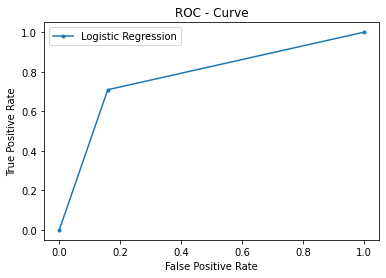


Estimator: Decision Tree Classifier
Best params are : {'criterion': 'gini', 'max_depth': 9}
Best training accuracy: 0.788
Test set accuracy score for best params: 0.796 
Confusion Matrix: 
[[470  70]
 [157 414]]


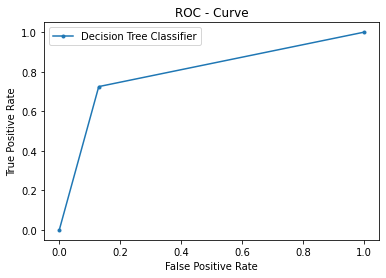


Estimator: Random Forest Classifier
Best params are : {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 6}
Best training accuracy: 0.806
Test set accuracy score for best params: 0.806 
Confusion Matrix: 
[[469  71]
 [145 426]]


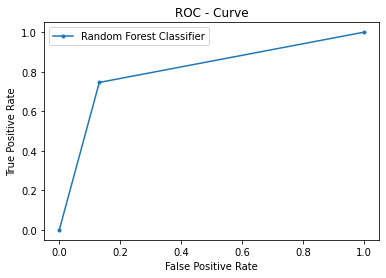


Estimator: Support Vector Machine
Best params are : {'C': 9, 'kernel': 'rbf'}
Best training accuracy: 0.756
Test set accuracy score for best params: 0.748 
Confusion Matrix: 
[[456  84]
 [196 375]]


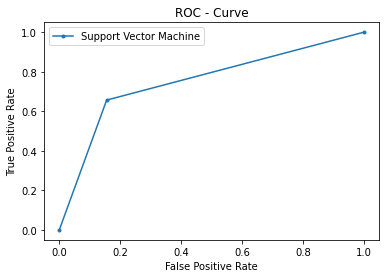


Estimator: Gausian NB
Best params are : {'var_smoothing': 0.001873817422860383}
Best training accuracy: 0.733
Test set accuracy score for best params: 0.725 
Confusion Matrix: 
[[411 129]
 [177 394]]


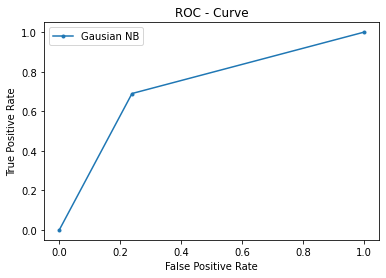


Estimator: Bernoulli NB
Best params are : {'alpha': 0.5}
Best training accuracy: 0.746
Test set accuracy score for best params: 0.736 
Confusion Matrix: 
[[443  97]
 [196 375]]


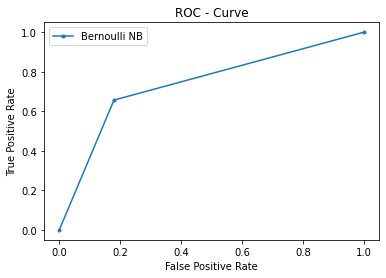


Classifier with best test set accuracy: Random Forest Classifier


In [18]:
warnings.filterwarnings("ignore")

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    gs.fit(x_train, y_train)
    print('Best params are : %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    
    # Predict on test data with best params
    y_pred = gs.predict(x_test)
    
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    
    # Confusion matrix for model
    print('Confusion Matrix:', f'\n{confusion_matrix(y_test, y_pred)}')
    
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker='.', label=f'{grid_dict[idx]}')
    # axis labels
    plt.title('ROC - Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()    
    
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

In [19]:
# # Now we can create k train-test splits using KFold
# from sklearn.model_selection import KFold

# # Using KFold instead of calling multiple times train_test_split to ensure that each
# # sample goes into a single split only
# kf = KFold(n_splits=5, random_state=45, shuffle=True)

# split = 0
# scores = []
# for train_index, test_index in kf.split(X):
    
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
#     result = single_grid_search(X_train, y_train)
    
#     decision_tree = result.best_estimator_
#     score = decision_tree.score(X_test, y_test)
#     scores.append(score)
#     print("### Split {}: Accuracy is {:.2f}% ###".format(split := split + 1, score*100))
    
# print("The mean generalization accuracy of the model is {:.2f}% (+/- {:.2f}%)".format(np.mean(scores) * 100, np.std(scores) * 100))

## Model evaluation and visualization of parameters

Feature ranking:
1. Width(0.124423)
2. Thickness(0.084058)
3. Hardness_2(0.063688)
4. nb(0.061185)
5. ti(0.059284)
6. p(0.058946)
7. mn(0.054664)
8. c(0.051737)
9. Hardness_1(0.046911)
10. KT1(0.038788)
11. b(0.035685)
12. si(0.034952)
13. s(0.034415)
14. NB0(0.027743)
15. n(0.027216)
16. cr(0.026531)
17. al(0.025082)
18. ma(0.024428)
19. mo(0.021346)
20. va(0.017054)


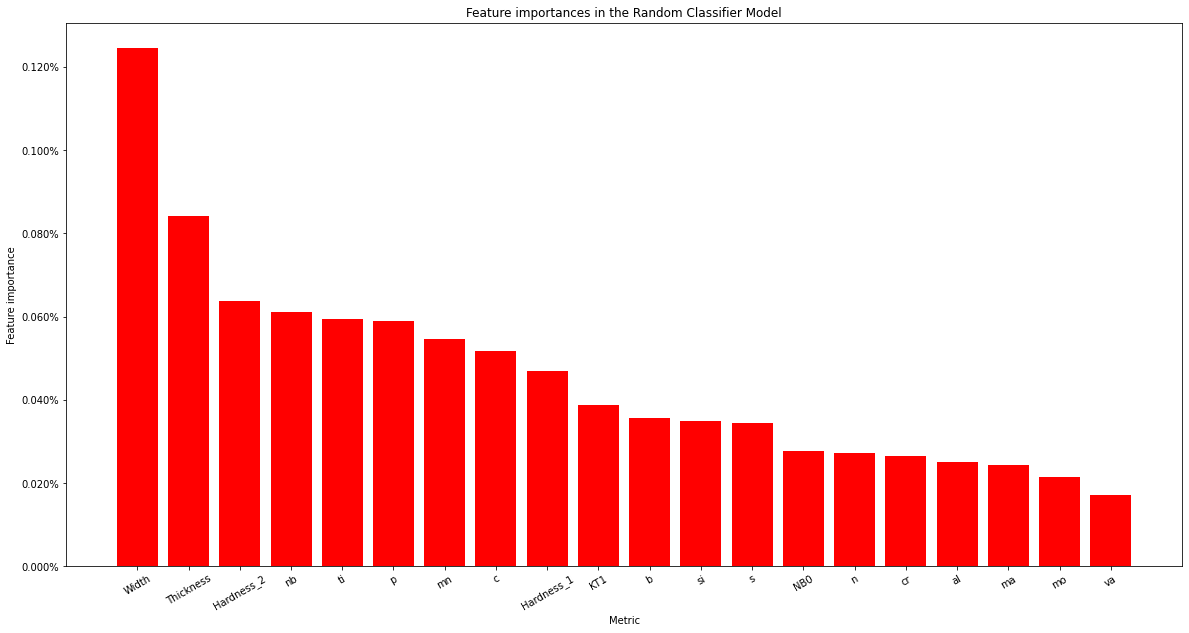

In [20]:
rand_forest = RandomForestClassifier(criterion='gini', max_depth=12, min_samples_split=12)
rand_forest.fit(x_train, y_train)
importances = rand_forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in rand_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
feature_names = [list(X.columns)[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")

for f in np.arange(0,20):
    print(f"%d. %s(%f)" %(f+1, feature_names[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Feature importances in the Random Classifier Model")
ax.bar(np.arange(0,20), importances[indices][0:20],
        color="r", align="center")
plt.xticks(np.arange(0,20), feature_names[:20], rotation=30)
plt.xlabel('Metric')
plt.ylabel('Feature importance')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

### Retrain model

In [21]:
df_balanced_coils = pd.concat([df_good_coils, df_bad_coils]).sample(frac=1).reset_index(drop=True).dropna()
contracted = df_balanced_coils.contracted
df_balanced_coils = df_balanced_coils.loc[:,feature_names[:20]].join(contracted)
print(df_balanced_coils)


X = df_balanced_coils.iloc[:,:-1]
y = df_balanced_coils.contracted
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

         Width  Thickness  Hardness_2        nb        ti         p  \
0     7.300540   0.832909    4.682131 -6.907755  5.318120  4.812184   
1     7.311753   1.627278    4.521789  0.693147  6.327937  4.718499   
2     7.406832   0.717840    4.595120  1.098612  1.386294  4.574711   
3     7.203777   0.703098    4.672829 -6.907755  5.262690  4.465908   
4     7.138391   0.896088    4.644391 -6.907755  2.639057  5.117994   
...        ...        ...         ...       ...       ...       ...   
5549  7.109634   0.412110    4.634729 -6.907755  2.079442  4.875197   
5550  7.255803   0.810930    4.983607  5.384495  5.505332  4.779123   
5551  7.269826   1.261298    4.795791  5.472271  2.639057  5.049856   
5552  7.098871   0.385262    4.624973 -6.907755  2.197225  4.290459   
5553  7.509445   1.272566    4.672829  3.555348  4.897840  6.593045   

             mn         c  Hardness_1  KT1  ...        si         s  NB0  \
0      7.688455  6.075346    9.239122  1.0  ...  4.174387  4.744932  0.

Performing model optimizations...

Estimator: Logistic Regression
Best params are : {'max_iter': 1000, 'multi_class': 'multinomial'}
Best training accuracy: 0.752
Test set accuracy score for best params: 0.729 
Confusion Matrix: 
[[424 125]
 [176 386]]


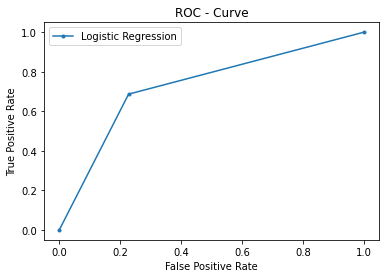


Estimator: Decision Tree Classifier
Best params are : {'criterion': 'gini', 'max_depth': 9}
Best training accuracy: 0.789
Test set accuracy score for best params: 0.784 
Confusion Matrix: 
[[452  97]
 [143 419]]


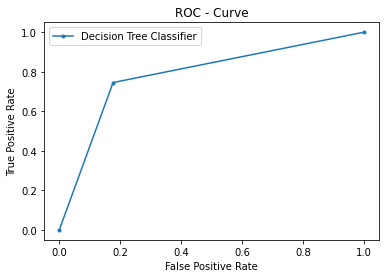


Estimator: Random Forest Classifier
Best params are : {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 3}
Best training accuracy: 0.819
Test set accuracy score for best params: 0.794 
Confusion Matrix: 
[[455  94]
 [135 427]]


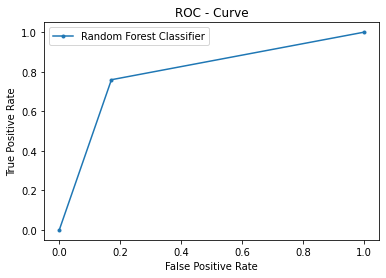


Estimator: Support Vector Machine
Best params are : {'C': 12, 'kernel': 'rbf'}
Best training accuracy: 0.773
Test set accuracy score for best params: 0.753 
Confusion Matrix: 
[[426 123]
 [151 411]]


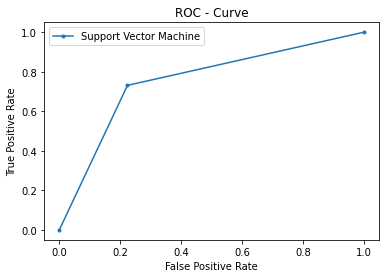


Estimator: Gausian NB
Best params are : {'var_smoothing': 0.0003511191734215131}
Best training accuracy: 0.687
Test set accuracy score for best params: 0.658 
Confusion Matrix: 
[[505  44]
 [336 226]]


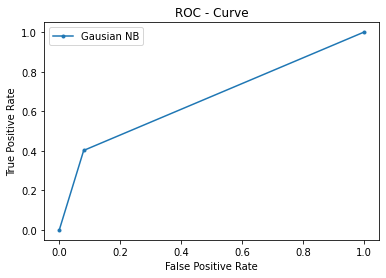


Estimator: Bernoulli NB
Best params are : {'alpha': 0.1}
Best training accuracy: 0.660
Test set accuracy score for best params: 0.653 
Confusion Matrix: 
[[480  69]
 [317 245]]


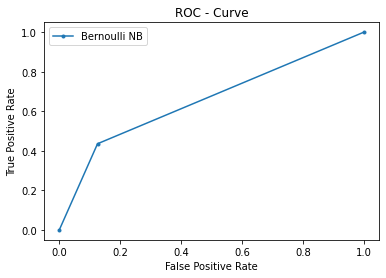


Classifier with best test set accuracy: Random Forest Classifier

Saved Random Forest Classifier grid search pipeline to file: best_grid_search_pipeline.pkl


In [22]:
warnings.filterwarnings("ignore")

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    gs.fit(x_train, y_train)
    print('Best params are : %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    
    # Predict on test data with best params
    y_pred = gs.predict(x_test)
    
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    
    # Confusion matrix for model
    print('Confusion Matrix:', f'\n{confusion_matrix(y_test, y_pred)}')
    
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker='.', label=f'{grid_dict[idx]}')
    # axis labels
    plt.title('ROC - Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()    
    
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])


# Save best grid search pipeline to file
dump_file = 'best_grid_search_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))